# How to do periodic interpolation using `xarray`

* I need this to link MCS track data to ERA5 env conditions. 
* Also, use to answer this SO question: https://stackoverflow.com/questions/61214010/interpolation-periodic-boundaries-with-xarray
* Use idea from here: https://stackoverflow.com/questions/60908274/plotting-data-from-netcdf-with-cartopy-isnt-plotting-data-at-0-longitude/60913814#60913814

In [62]:
import numpy as np
import xarray as xr

data = np.arange(360 * 180).reshape(360, 180)

lon = np.linspace(0.5, 359.5, 360)
lat = np.linspace(-89.5, 89.5, 180)

da = xr.DataArray(
    coords=dict(
        lon=lon,
        lat=lat,
    ),
    data=data,
)

print(da.interp(lon=0.3, lat=32).values)
print(da.interp(lon=359.7, lat=32).values)

def xr_add_cyclic_points(da):
    """
    Add cyclic points at start and end of `lon` dimension of data array.
    
    Inputs
    da: xr.DataArray including dimensions (lat,lon)
    """
    # Borrows heavily from cartopy.util.add_cyclic point, but adds at start and end.

    lon_idx = da.dims.index('lon')
    
    start_slice = [slice(None)] * da.ndim
    end_slice = [slice(None)] * da.ndim
    start_slice[lon_idx] = slice(0, 1)
    end_slice[lon_idx] = slice(-1, None)
    
    wrap_data = np.concatenate([da.values[tuple(end_slice)], da.values, da.values[tuple(start_slice)]], axis=lon_idx)
    wrap_lon = np.concatenate([da.lon.values[-1:] - 360, da.lon.values, da.lon.values[0:1] + 360])

    # Generate output DataArray with new data but same structure as input
    outp_da = xr.DataArray(data=wrap_data, 
                           coords=dict(lat=da.lat, lon=wrap_lon), 
                           dims=da.dims, 
                           attrs=da.attrs)
    
    return outp_da

da_wrapped = xr_add_cyclic_points(da)

print(da_wrapped.interp(lon=0.3, lat=32).values)
print(da_wrapped.interp(lon=359.7, lat=32).values)

nan
nan
13045.5
51817.500000000735


In [40]:
from cartopy.util import add_cyclic_point
import xarray as xr 

def xr_add_cyclic_point(da):
    """
    Inputs
    da: xr.DataArray with dimensions (time,latitude,longitude)
    """
    # Taken from https://stackoverflow.com/a/60913814/54557
    # Use add_cyclic_point to pad input data.
    lon_idx = da.dims.index('longitude')
    wrap_data, wrap_lon = add_cyclic_point(da.values, coord=da.longitude, axis=lon_idx)

    new_coords = {dim: da.coords[dim] for dim in da.dims}
    new_coords['longitude'] = wrap_lon

    # Generate output DataArray with new data but same structure as input.
    outp_da = xr.DataArray(data=wrap_data,
                           coords=new_coords,
                           dims=da.dims,
                           attrs=da.attrs)

    return outp_da

In [41]:
e5 = xr.open_dataarray('/datacentre/archvol5/qb134/archive/spot-8557-an_sfc/2020/01/01/ecmwf-era5_oper_an_sfc_202001010000.cape.nc')

In [42]:
e5p = xr_add_cyclic_point(e5)

In [43]:
(e5p.values[0][:, 0] == e5p.values[0][:, -1]).all()

True

In [44]:
e5.coords['time']

<xarray.DataArray 'time' (time: 1)>
array(['2020-01-01T00:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2020-01-01
Attributes:
    long_name:  time

In [45]:
e5 = xr.open_dataarray('/datacentre/archvol5/qb145/archive/spot-42624-2020/01/01/ecmwf-era5_oper_an_ml_202001010000.u.nc')

In [46]:
e5p = xr_add_cyclic_point(e5)

In [47]:
e5p

<xarray.DataArray (time: 1, level: 137, latitude: 721, longitude: 1441)>
array([[[[-16.135323  , -16.135323  , -16.135323  , ..., -16.135323  ,
          -16.135323  , -16.135323  ],
         [-15.732285  , -15.722916  , -15.708855  , ..., -15.75103   ,
          -15.741661  , -15.732285  ],
         [-14.930901  , -14.921532  , -14.907471  , ..., -14.944962  ,
          -14.935585  , -14.930901  ],
         ...,
         [  1.7107391 ,   1.6357574 ,   1.5560875 , ...,   1.870079  ,
            1.7950974 ,   1.7107391 ],
         [  1.7060547 ,   1.6263847 ,   1.5420265 , ...,   1.8653946 ,
            1.7810364 ,   1.7060547 ],
         [  6.795555  ,   6.795555  ,   6.795555  , ...,   6.795555  ,
            6.795555  ,   6.795555  ]],

        [[-32.964424  , -32.964424  , -32.964424  , ..., -32.964424  ,
          -32.964424  , -32.964424  ],
         [-34.876503  , -34.899933  , -34.928055  , ..., -34.815575  ,
          -34.84838   , -34.876503  ],
         [-35.171745  , -35.20455   , -35.232674  , ..., -35.110825  ,
          -35.13894   , -35.171745  ],
...
         [ -4.3816643 ,  -4.3863525 ,  -4.3957253 , ...,  -4.362919  ,
           -4.3722916 ,  -4.3816643 ],
         [ -4.808136  ,  -4.8128204 ,  -4.822193  , ...,  -4.794075  ,
           -4.7987633 ,  -4.808136  ],
         [  6.13945   ,   6.13945   ,   6.13945   , ...,   6.13945   ,
            6.13945   ,   6.13945   ]],

        [[ -4.911236  ,  -4.911236  ,  -4.911236  , ...,  -4.911236  ,
           -4.911236  ,  -4.911236  ],
         [ -4.2410736 ,  -4.2270126 ,  -4.2129517 , ...,  -4.2645035 ,
           -4.255131  ,  -4.2410736 ],
         [ -3.5521622 ,  -3.5427895 ,  -3.5334167 , ...,  -3.5755959 ,
           -3.561535  ,  -3.5521622 ],
         ...,
         [ -3.5709076 ,  -3.5802803 ,  -3.589653  , ...,  -3.5568466 ,
           -3.5662193 ,  -3.5709076 ],
         [ -3.9551964 ,  -3.9598846 ,  -3.9692574 , ...,  -3.9411392 ,
           -3.9458237 ,  -3.9551964 ],
         [  5.2068443 ,   5.2068443 ,   5.2068443 , ...,   5.2068443 ,
            5.2068443 ,   5.2068443 ]]]], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 2020-01-01
  * level      (level) int32 1 2 3 4 5 6 7 8 ... 130 131 132 133 134 135 136 137
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8 360.0
Attributes:
    units:          m s**-1
    long_name:      U component of wind
    standard_name:  eastward_wind

In [48]:
(e5p.values[0, :, :, 0] == e5p.values[0, :, :, -1]).all()

True

SO Question on `xgcm`




In [64]:
    import numpy as np
    import xarray as xr
    import xgcm as xg

    data = np.arange(360 * 180).reshape(360, 180)

    lon = np.linspace(0.5, 359.5, 360)
    lat = np.linspace(-89.5, 89.5, 180)

    da = xr.DataArray(
        coords=dict(
            lon=lon,
            lat=lat,
        ),
        data=data,
    )
    ds = da.to_dataset(name='data')

    # Setup xgcm grid with periodic lon.
    grid = xg.Grid(ds, coords={'lon': {'center': 'lon'}, 'lat': {'center': 'lat'}}, periodic=['lon'])

    # lon/lat values of points - first point is (0.1, 23) and is outside the non-periodic boundary of values.
    points = np.array([[0.1, 23], [359.9, 43]])

    # What comes next?
    interp_values = grid.interp(...)


TypeError: Grid.interp() missing 1 required positional argument: 'axis'

# Try to do same thing using `xgcm`

Not working. I do not find the documentation for `xgcm` very clear. I am not sure it can be used how I want - to interpolate a 2D field to a point/set of points.

In [15]:
import numpy as np
import xarray as xr
import xgcm as xg

In [37]:
ds = xr.Dataset(
    coords=da.coords,
    data_vars=dict(data=da),
)
grid = xg.Grid(ds, coords={"lon": {"center": "lon"}, "lat": {"center": "lat"}}, periodic=["lon"])
grid

<xgcm.Grid>
lon Axis (periodic, boundary=None):
  * center   lon
lat Axis (not periodic, boundary=None):
  * center   lat

In [59]:
da_ = xr.DataArray(data=[[1]], coords=dict(lon=[0.3], lat=[32]))

In [60]:
grid.interp(da_, ['lon', 'lat'])

KeyError: 'lon'

In [57]:
debug

> /home/users/mmuetz/miniconda3/envs/mcs_prime_env/lib/python3.10/site-packages/xgcm/grid.py(1860)_create_1d_grid_ufunc_signatures()
   1858         signatures = []
   1859         for ax_name in axis:
-> 1860             ax = self.axes[ax_name]
   1861 
   1862             from_pos, _ = ax._get_position_name(da)  # removed `dim` since it wasnt used

--KeyboardInterrupt--

KeyboardInterrupt: Interrupted by user


In [26]:
a.dims

AttributeError: 'numpy.ndarray' object has no attribute 'dims'

In [44]:
    import xarray as xr
    import numpy as np

    ds = xr.Dataset(
        coords={
            "x_c": (
                ["x_c"],
                np.arange(1, 10),
            ),
            "x_g": (
                ["x_g"],
                np.arange(0.5, 9),
            ),
        }
    )
    ds

<xarray.Dataset>
Dimensions:  (x_c: 9, x_g: 9)
Coordinates:
  * x_c      (x_c) int64 1 2 3 4 5 6 7 8 9
  * x_g      (x_g) float64 0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5
Data variables:
    *empty*

In [45]:
    from xgcm import Grid

    grid = Grid(ds, coords={"X": {"center": "x_c", "left": "x_g"}})
    grid

<xgcm.Grid>
X Axis (periodic, boundary=None):
  * center   x_c --> left
  * left     x_g --> center

<xarray.DataArray 'x_c' (x_c: 9)>
array([ 6.42787610e-01,  9.84807753e-01,  8.66025404e-01,  3.42020143e-01,
       -3.42020143e-01, -8.66025404e-01, -9.84807753e-01, -6.42787610e-01,
       -2.44929360e-16])
Coordinates:
  * x_c      (x_c) int64 1 2 3 4 5 6 7 8 9


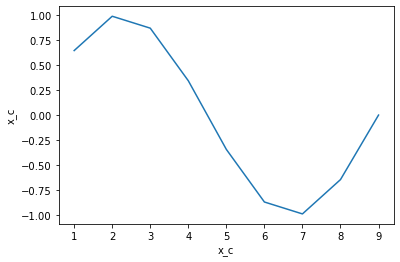

In [47]:
    import matplotlib.pyplot as plt

    da = np.sin(ds.x_c * 2 * np.pi / 9)
    print(da)
#     @savefig grid_test_data.png
    da.plot()
#    plt.close()


In [48]:
    da_interp = grid.interp(da, axis="X")
    da_interp

<xarray.DataArray 'x_c' (x_g: 9)>
array([ 3.21393805e-01,  8.13797681e-01,  9.25416578e-01,  6.04022774e-01,
        1.11022302e-16, -6.04022774e-01, -9.25416578e-01, -8.13797681e-01,
       -3.21393805e-01])
Coordinates:
  * x_g      (x_g) float64 0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5

In [49]:
da

<xarray.DataArray 'x_c' (x_c: 9)>
array([ 6.42787610e-01,  9.84807753e-01,  8.66025404e-01,  3.42020143e-01,
       -3.42020143e-01, -8.66025404e-01, -9.84807753e-01, -6.42787610e-01,
       -2.44929360e-16])
Coordinates:
  * x_c      (x_c) int64 1 2 3 4 5 6 7 8 9

In [50]:
ds.x_c

<xarray.DataArray 'x_c' (x_c: 9)>
array([1, 2, 3, 4, 5, 6, 7, 8, 9])
Coordinates:
  * x_c      (x_c) int64 1 2 3 4 5 6 7 8 9

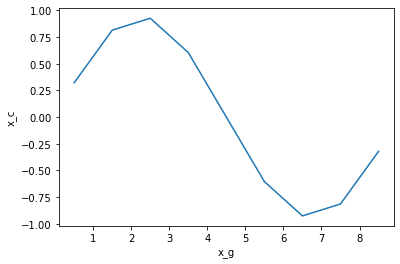

In [51]:
da_interp.plot()